In [1]:
# Import necessary libraries only
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras import layers, Model
from matplotlib import pyplot as plt

2025-05-17 16:44:58.164011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747493098.229227    6334 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747493098.248881    6334 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747493098.373934    6334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747493098.373955    6334 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747493098.373957    6334 computation_placer.cc:177] computation placer alr

In [2]:
# Set the path to the data directory
data_path = "../data/KuaiRec/data/"

# Load all required datasets
print("Loading big matrix...")
big_matrix = pd.read_csv(data_path + "big_matrix.csv")
print("Loading small matrix...")
small_matrix = pd.read_csv(data_path + "small_matrix.csv")
print("Loading social network...")
social_network = pd.read_csv(data_path + "social_network.csv")
print("Loading item features...")
item_categories = pd.read_csv(data_path + "item_categories.csv")
item_categories["feat"] = item_categories["feat"].map(eval)
print("Loading user features...")
user_features = pd.read_csv(data_path + "user_features.csv")
print("Loading items' daily features...")
item_daily_features = pd.read_csv(data_path + "item_daily_features.csv")
print("All data loaded.")

Loading big matrix...
Loading small matrix...
Loading social network...
Loading item features...
Loading user features...
Loading items' daily features...
All data loaded.


In [3]:
# Prepare the interaction matrix for training and testing
interaction_matrix = big_matrix[["user_id", "video_id", "watch_ratio"]]
interaction_matrix = interaction_matrix[interaction_matrix['watch_ratio'] <= 2]
interaction_matrix['watch_ratio'] = (interaction_matrix['watch_ratio'] - interaction_matrix['watch_ratio'].min()) / (interaction_matrix['watch_ratio'].max() - interaction_matrix['watch_ratio'].min())

test_matrix = small_matrix[["user_id", "video_id", "watch_ratio"]]
test_matrix = test_matrix[test_matrix['watch_ratio'] <= 2]
test_matrix['watch_ratio'] = (test_matrix['watch_ratio'] - test_matrix['watch_ratio'].min()) / (test_matrix['watch_ratio'].max() - test_matrix['watch_ratio'].min())

In [4]:
# Prepare user features (one-hot encoded, fill missing, shift indices)
onehot_cols = [f"onehot_feat{i}" for i in range(18)]
users = user_features[["user_id"] + onehot_cols].copy()

users[onehot_cols] = users[onehot_cols].fillna(-1).astype(int) + 1
users["user_id"] = users["user_id"].astype(int)

In [5]:
# Helper function to shift and pad tag lists for consistent input length
def shift_and_pad(tags, max_len=31):
    shifted = [tag + 1 for tag in tags]
    padded = shifted[:max_len] + [0] * (max_len - len(shifted))
    return padded

# Aggregate daily features for each video and merge with static features
agg_funcs = {
    "author_id": "last",
    "video_duration": "last",
    "play_progress": "mean",
    "video_tag_id": "last",
    "play_cnt": "sum",
    "like_cnt": "sum",
    "share_cnt": "sum",
    "comment_cnt": "sum"
}
videos = item_daily_features.groupby("video_id").agg(agg_funcs)
videos = videos.merge(item_categories, on="video_id", how="left").set_index("video_id")

videos = videos[videos["video_duration"] <= 20000]
videos["video_duration"] = videos["video_duration"].fillna(0).astype(int)

videos["video_tag_id"] = videos["video_tag_id"].fillna(-1).astype(int) + 1

videos["feat"] = videos["feat"].apply(shift_and_pad)

In [6]:
# Free up memory by deleting large unused dataframes
del small_matrix
del big_matrix
del item_daily_features
del item_categories
del user_features

In [7]:
# Model hyperparameters
EMBEDDING_DIM = 64
TAG_EMBED_DIM = 64
NUM_TAGS = 31
USER_VOCAB_SIZE = [2, 8, 30, 1076, 12, 10, 3, 47, 340, 7, 5, 3, 2, 2, 2, 2, 2, 2]
BATCH_SIZE = 256
NB_EPOCHS = 10
LEARNING_RATE = 0.001
MAX_AUTHOR_ID = videos["author_id"].max()
MAX_TAG_ID = videos["video_tag_id"].max() + 1

TOP_K = 100

In [8]:
# User tower model definition
class UserTower(Model):
    def __init__(self):
        super(UserTower, self).__init__()
        self.embedding_layers = []
        # Embedding layers for each categorical user feature
        for vocab_size in USER_VOCAB_SIZE:
            self.embedding_layers.append(Embedding(input_dim=vocab_size + 1, output_dim=TAG_EMBED_DIM))
        # Dense layers for user representation
        self.value_layers = tf.keras.Sequential([
            Dense(512, activation="relu"),
            Dense(512, activation="relu"),
            Dense(256, activation="relu"),
            Dense(256, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(EMBEDDING_DIM)
        ])
        
    def call(self, inputs):
        user_embeds = []
        for i in range(inputs.shape[1]):
            input_i = inputs[:, i]
            embed = self.embedding_layers[i](input_i)
            user_embeds.append(embed)
            
        user_concat = tf.concat(user_embeds, axis=-1)
        return self.value_layers(user_concat)

# Video tower model definition
class VideoTower(Model):
    def __init__(self):
        super(VideoTower, self).__init__()
        # Embedding for author and tag IDs
        self.author_manager = tf.keras.Sequential([
            Input(shape=(), dtype=tf.int32, name="video_tag_id"),
            Embedding(input_dim=MAX_AUTHOR_ID + 1, output_dim=TAG_EMBED_DIM)
        ])
        
        self.tag_id_manager = tf.keras.Sequential([
            Input(shape=(), dtype=tf.int32, name="author_id"),
            Embedding(input_dim=MAX_TAG_ID + 1, output_dim=TAG_EMBED_DIM)
        ])
        
        # Embedding for tag list
        self.tag_manager = tf.keras.Sequential([
            Embedding(input_dim=NUM_TAGS + 1, output_dim=TAG_EMBED_DIM, mask_zero=True),
            layers.GlobalAveragePooling1D()
        ])
        
        # Dense layers for numerical features
        self.value_layers = tf.keras.Sequential([
            Dense(512, activation="relu"),
            Dense(512, activation="relu"),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(128, activation='relu'),
            Dense(EMBEDDING_DIM)
        ])
        self.last = Dense(EMBEDDING_DIM)
        
    def call(self, tag_input, author_id, tag_id, numeric_input):
        tag_id_vector = self.tag_id_manager(tag_id)
        author_vector = self.author_manager(author_id)
        tag_vector = self.tag_manager(tag_input)
        numeric_vector = self.value_layers(numeric_input)
        
        combined = tf.concat([tag_vector, numeric_vector, tag_id_vector, author_vector], axis=1)
        return self.last(combined)

# Two-tower fusion model
class TwoTowerModel(Model):
    def __init__(self, user_tower, video_tower):
        super(TwoTowerModel, self).__init__()
        self.user_tower = user_tower
        self.video_tower = video_tower
        
    def call(self, inputs):
        user_input, video_tag_input, video_author_input, video_tag_id_input, video_continuous_input = inputs
        user_emb = self.user_tower(user_input)
        video_emb = self.video_tower(video_tag_input, video_author_input, video_tag_id_input, video_continuous_input)
        user_emb = tf.linalg.l2_normalize(user_emb, axis=1)
        video_emb = tf.linalg.l2_normalize(video_emb, axis=1)
        dot_product = layers.Dot(axes=1)([user_emb, video_emb])
        
        return dot_product

In [9]:

# Helper to create tf.data.Dataset for training or evaluation
def create_dataset(interaction_matrix):
    interaction_matrix = interaction_matrix.merge(users, on="user_id", how="left")
    interaction_matrix = interaction_matrix.merge(videos, on="video_id", how="left")
    interaction_matrix = interaction_matrix.dropna()
    
    user_data = interaction_matrix[[f"onehot_feat{i}" for i in range(18)]].values
    video_tag_data = np.array(interaction_matrix["feat"].tolist(), dtype=np.int32)
    video_author_id = interaction_matrix["author_id"].values
    video_tag_id = interaction_matrix["video_tag_id"].values
    video_continuous_data = interaction_matrix[["video_duration", "play_progress"]].values
    labels = interaction_matrix["watch_ratio"].values
    
    dataset = tf.data.Dataset.from_tensor_slices(((user_data, video_tag_data, video_author_id, video_tag_id, video_continuous_data), labels))
    dataset = dataset.shuffle(buffer_size=len(user_data))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [ ]:
# Create training dataset
dataset_train = create_dataset(interaction_matrix)

# Instantiate and compile the two-tower model
user_tower = UserTower()
video_tower = VideoTower()
tower_model = TwoTowerModel(user_tower=user_tower, video_tower=video_tower)
tower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

# Train the model
history = tower_model.fit(
    dataset_train,
    epochs=NB_EPOCHS,
    verbose=1
)

I0000 00:00:1747493129.222846    6334 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6092 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/10


15133/15140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - mae: 0.1313

2025-05-17 16:31:29.844632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 152 bytes spill stores, 152 bytes spill loads

2025-05-17 16:31:29.890708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345', 488 bytes spill stores, 488 bytes spill loads

2025-05-17 16:31:30.300812: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_345_0', 1464 bytes spill stores, 1156 bytes spill loads

2025-05-17 16:31:30.655144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_352_0', 1084 bytes spill stores, 1880 bytes spill loads

2025-05-17 16:31:31.134163: 

15140/15140 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0300 - mae: 0.1313
Test loss: 0.030025362968444824
Test MAE: 0.1312691569328308


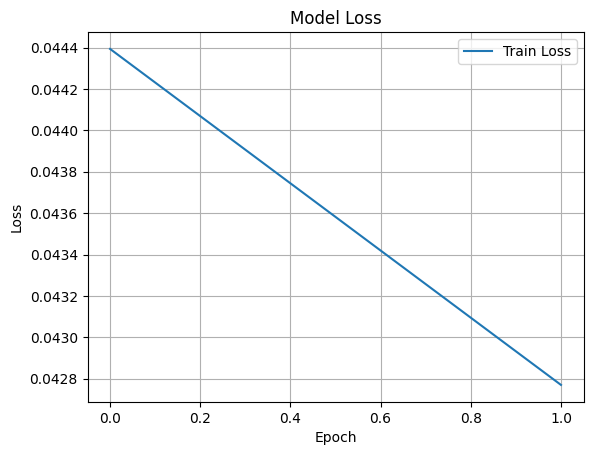

In [ ]:
# Evaluate the model on the test set and plot loss curves
dataset_test = create_dataset(test_matrix)
loss, mae = tower_model.evaluate(dataset_test)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")

plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prepare dataset for ranking metrics
def prepare_dataset_for_metrics(matrix):
    matrix = matrix.merge(users, on="user_id", how="left")
    matrix = matrix.merge(videos, on="video_id", how="left")
    matrix = matrix.dropna()
    
    user_data = matrix[[f"onehot_feat{i}" for i in range(18)]].values
    video_tag_data = np.array(matrix["feat"].tolist(), dtype=np.int32)
    video_author_id = matrix["author_id"].values
    video_tag_id = matrix["video_tag_id"].values
    video_continuous_data = matrix[["video_duration", "play_progress"]].values
    
    dataset = tf.data.Dataset.from_tensor_slices(((user_data, video_tag_data, video_author_id, video_tag_id, video_continuous_data), matrix["watch_ratio"].values))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset, matrix

metrics_dataset, matrix = prepare_dataset_for_metrics(test_matrix)
predictions = tower_model.predict(metrics_dataset, verbose=1)
matrix["predictions"] = predictions

# Helper functions to get top predicted and real items per user
def get_top_items(group):
    return group.sort_values("predictions", ascending=False)["video_id"].tolist()
def get_real_top_items(group):
    return group.sort_values("watch_ratio", ascending=False)["video_id"].tolist()

matrix = (
    matrix.groupby("user_id")
    .apply(lambda group: pd.Series({
        "predicted": get_top_items(group),
        "real": get_real_top_items(group)
    }))
    .reset_index()
)

15140/15140 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step


/tmp/ipykernel_129208/4242784526.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


In [ ]:
# =======================
# Ranking Metrics Section
# =======================

# Build dictionaries for predictions and ground truth
predictions_dict = matrix.set_index("user_id")["predicted"].to_dict()
ground_truth_dict = matrix.set_index("user_id")["real"].to_dict()

# Precision@K
def precision_at_k(predictions, ground_truth):
    precisions = []
    for user, recommended_items in predictions.items():
        relevant_items = set(ground_truth.get(user, []))
        top_k = recommended_items[:TOP_K]
        hit_count = len(set(top_k) & relevant_items)
        precisions.append(hit_count / TOP_K)
    return sum(precisions) / len(precisions)

# Recall@K
def recall_at_k(predictions, ground_truth):
    recalls = []
    for user, recommended_items in predictions.items():
        relevant_items = set(ground_truth.get(user, []))
        if not relevant_items:
            continue
        top_k = recommended_items[:TOP_K]
        hit_count = len(set(top_k) & relevant_items)
        recalls.append(hit_count / len(relevant_items))
    return sum(recalls) / len(recalls)

# NDCG@K
def ndcg_at_k(predictions, ground_truth):
    def dcg(recommended, relevant):
        return sum(1 / math.log2(i + 2) for i, item in enumerate(recommended) if item in relevant)
    ndcgs = []
    for user, recommended_items in predictions.items():
        relevant_items = ground_truth.get(user, set())
        top_k = recommended_items[:TOP_K]
        ideal_dcg = dcg(sorted(relevant_items, key=lambda x: 1, reverse=True)[:TOP_K], relevant_items)
        actual_dcg = dcg(top_k, relevant_items)
        if ideal_dcg == 0:
            continue
        ndcgs.append(actual_dcg / ideal_dcg)
    return sum(ndcgs) / len(ndcgs)

# MAP@K
def average_precision_at_k(recommended, relevant):
    hits = 0
    sum_precisions = 0
    for i, item in enumerate(recommended[:TOP_K]):
        if item in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / min(len(relevant), TOP_K) if relevant else 0

def map_at_k(predictions, ground_truth):
    average_precisions = []
    for user, recommended_items in predictions.items():
        relevant_items = ground_truth.get(user, set())
        ap = average_precision_at_k(recommended_items, relevant_items)
        average_precisions.append(ap)
    return sum(average_precisions) / len(average_precisions)

In [ ]:
# =======================
# Evaluate metrics at different K
# =======================

TOP_K = 1
print("Precision@K:", precision_at_k(predictions_dict, ground_truth_dict))
print("Recall@K:", recall_at_k(predictions_dict, ground_truth_dict))
print("NDCG@K:", ndcg_at_k(predictions_dict, ground_truth_dict))
print("MAP@K:", map_at_k(predictions_dict, ground_truth_dict))

TOP_K = 10
print("Precision@K:", precision_at_k(predictions_dict, ground_truth_dict))
print("Recall@K:", recall_at_k(predictions_dict, ground_truth_dict))
print("NDCG@K:", ndcg_at_k(predictions_dict, ground_truth_dict))
print("MAP@K:", map_at_k(predictions_dict, ground_truth_dict))

TOP_K = 100
print("Precision@K:", precision_at_k(predictions_dict, ground_truth_dict))
print("Recall@K:", recall_at_k(predictions_dict, ground_truth_dict))
print("NDCG@K:", ndcg_at_k(predictions_dict, ground_truth_dict))
print("MAP@K:", map_at_k(predictions_dict, ground_truth_dict))

TOP_K = 500
print("Precision@K:", precision_at_k(predictions_dict, ground_truth_dict))
print("Recall@K:", recall_at_k(predictions_dict, ground_truth_dict))
print("NDCG@K:", ndcg_at_k(predictions_dict, ground_truth_dict))
print("MAP@K:", map_at_k(predictions_dict, ground_truth_dict))

Precision@K: 1.0
Recall@K: 0.00036529186794629216
NDCG@K: 1.0
MAP@K: 1.0
Precision@K: 1.0
Recall@K: 0.0036529186794629215
NDCG@K: 1.0
MAP@K: 1.0
Precision@K: 1.0
Recall@K: 0.03652918679462921
NDCG@K: 1.0
MAP@K: 1.0
Precision@K: 1.0
Recall@K: 0.18264593397314607
NDCG@K: 1.0
MAP@K: 1.0


In [ ]:
# Helper to get top-k recommendations for a user
def get_top_k_user(user_id, k):
    return predictions_dict[user_id][:k]

print(get_top_k_user(14, 10))

[723, 5464, 3118, 2590, 8298, 7135, 10062, 7049, 7559, 7594]
